In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoImageProcessor, logging
from datasets import load_dataset, enable_caching
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import ttest_ind, chi2_contingency
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

/opt/anaconda3/envs/notebook-7.0.8/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuration and Setup
os.environ['HF_HOME'] = os.path.join(".", "cache")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
enable_caching()
logging.set_verbosity_error()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# Data Files Configuration
train_file = os.path.join("dataset", "data_train.csv")
test_file = os.path.join("dataset", "data_eval.csv")
answer_space_file = os.path.join("dataset", "answer_space.txt")

In [4]:
# Load and prepare dataset
dataset = load_dataset("csv", data_files={"train": train_file, "test": test_file})
with open(answer_space_file) as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {'label': [answer_space.index(ans.split(",")[0].strip()) for ans in examples['answer']]},
    batched=True
)

Sample 1 Data:
Question: what is beneath the picture
Image ID: image1268


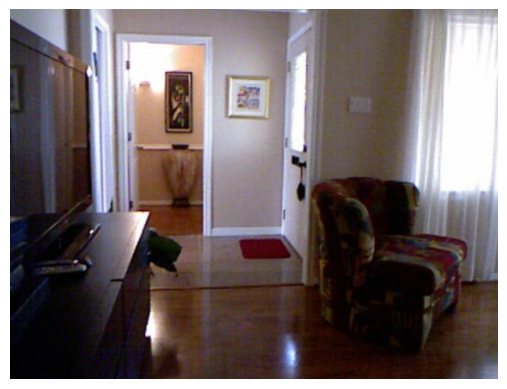

Sample 2 Data:
Question: what is in between the papers
Image ID: image638


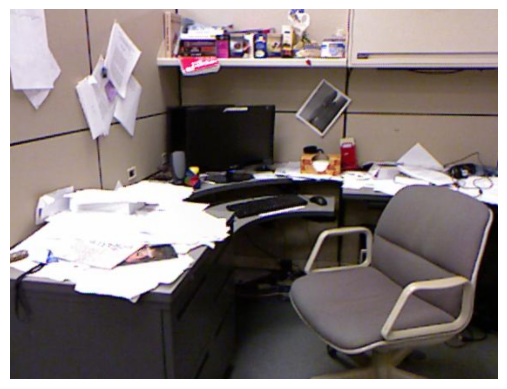

Sample 3 Data:
Question: what is the colour of towel
Image ID: image719


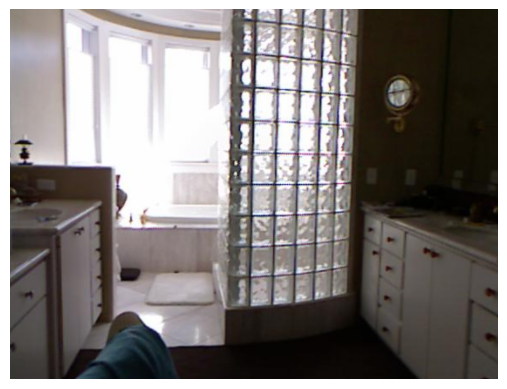

Sample 4 Data:
Question: what is on the left side of the rack
Image ID: image936


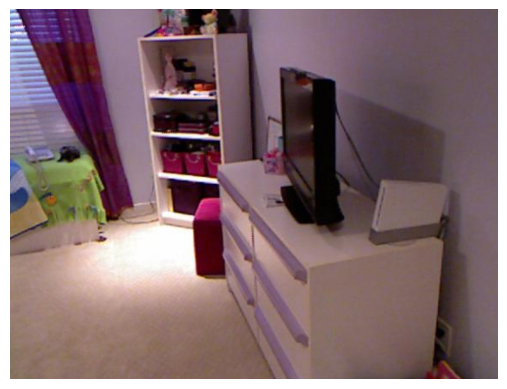

In [5]:
# Display Sample Data
def display_sample_data(dataset):
    samples = dataset['train'].shuffle(seed=42).select(range(4))
    for i, sample in enumerate(samples):
        print(f"Sample {i+1} Data:")
        print("Question:", sample['question'])
        print("Image ID:", sample['image_id'])
        img_path = os.path.join("dataset", "images", sample['image_id'] + ".png")
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

display_sample_data(dataset)

In [6]:
# Define MultimodalCollator
from dataclasses import dataclass
from typing import List

@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoImageProcessor

    def __call__(self, batch):
        questions = [item['question'] for item in batch]
        image_ids = [item['image_id'] for item in batch]
        labels = [item['label'] for item in batch]
        tokenized = self.tokenizer(questions, padding=True, truncation=True, return_tensors='pt')
        images = [Image.open(os.path.join("dataset", "images", img + ".png")).convert('RGB') for img in image_ids]
        processed_images = self.preprocessor(images=images, return_tensors='pt')
        return {'input_ids': tokenized['input_ids'], 'attention_mask': tokenized['attention_mask'], 'pixel_values': processed_images['pixel_values'], 'labels': torch.tensor(labels)}

In [7]:
# Initialize Tokenizer and Preprocessor
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
preprocessor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
collator = MultimodalCollator(tokenizer, preprocessor)

/opt/anaconda3/envs/notebook-7.0.8/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
class SimplifiedMultimodalVQAModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.text_encoder = nn.Embedding(30522, 768)  # Example dimensions
        self.image_encoder = nn.Conv2d(3, 256, kernel_size=3, stride=1, padding=1)
        self.fusion_layer = nn.Linear(1024, 256)
        self.classifier = nn.Linear(256, len(answer_space))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, pixel_values, labels, attention_mask=None, token_type_ids=None):
        # Use attention_mask if you have layers that utilize it, such as transformer models.
        text_features = self.text_encoder(input_ids).mean(dim=1)
        image_features = self.image_encoder(pixel_values).mean(dim=[2, 3])
        combined_features = torch.cat([text_features, image_features], dim=1)
        fused_features = self.dropout(self.relu(self.fusion_layer(combined_features)))
        logits = self.classifier(fused_features)
        loss = nn.CrossEntropyLoss()(logits, labels)
        return loss, logits

In [9]:
# Initialize model and optimizer
model = SimplifiedMultimodalVQAModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader):
        input_ids = batch['input_ids'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        loss, _ = model(input_ids, pixel_values, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [11]:
def calculate_advanced_statistics(predictions, true_labels):
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    # Creating contingency table
    contingency_table = np.histogram2d(true_labels, predictions, bins=[min(len(set(true_labels)), 10), min(len(set(predictions)), 10)])[0]
    
    # Adding a small constant to avoid zero counts
    contingency_table += 1

    t_stat, p_value = ttest_ind(predictions, true_labels)
    chi2_stat, chi2_p, _, _ = chi2_contingency(contingency_table)

    return t_stat, p_value, chi2_stat, chi2_p

In [12]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            loss, logits = model(**batch)
            total_loss += loss.item()
            all_preds.extend(logits.argmax(dim=-1).tolist())
            all_labels.extend(batch['labels'].tolist())
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    t_stat, p_value, chi2_stat, chi2_p = calculate_advanced_statistics(all_preds, all_labels)
    print("T-statistic:", t_stat, "P-value:", p_value)
    print("Chi-squared statistic:", chi2_stat, "Chi-squared P-value:", chi2_p)
    return total_loss / len(dataloader), accuracy, f1, t_stat, p_value, chi2_stat, chi2_p

In [13]:
def plot_metrics(training_losses, validation_losses, accuracies, f1_scores, t_stats, chi2_stats):
    epochs = range(1, len(training_losses) + 1)
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, training_losses, 'b-', label='Training Loss')
    plt.plot(epochs, validation_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, accuracies, 'g-', label='Accuracy')
    plt.plot(epochs, f1_scores, 'm-', label='F1 Score')
    plt.title('Accuracy and F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, t_stats, 'c-', label='T-Statistic')
    plt.plot(epochs, chi2_stats, 'y-', label='Chi-squared Statistic')
    plt.title('Advanced Statistical Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Statistic Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [14]:
# Data Loaders
train_dataloader = DataLoader(dataset['train'], batch_size=32, shuffle=True, collate_fn=collator)
test_dataloader = DataLoader(dataset['test'], batch_size=32, collate_fn=collator)

In [15]:
# Initialize lists to store metrics
training_losses = []
validation_losses = []
accuracies = []
f1_scores = []
t_stats = []
chi2_stats = []

In [19]:
# Example training loop
num_epochs = 5
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_dataloader, optimizer, device)
    val_loss, accuracy, f1, t_stat, p_value, chi2_stat, chi2_p = evaluate(model, test_dataloader, device)
    
    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    accuracies.append(accuracy)
    f1_scores.append(f1)
    t_stats.append(t_stat)
    chi2_stats.append(chi2_stat)

Epoch 1/5


100%|███████████████████████████████████████████| 78/78 [01:25<00:00,  1.09s/it]


T-statistic: 3.0498550023031785 P-value: 0.002301544450703847
Chi-squared statistic: 2016.4346596965634 Chi-squared P-value: 0.0
Epoch 2/5


100%|███████████████████████████████████████████| 78/78 [01:21<00:00,  1.04s/it]


T-statistic: 2.6093034644676134 P-value: 0.009099779592489627
Chi-squared statistic: 1859.231006886848 Chi-squared P-value: 0.0
Epoch 3/5


100%|███████████████████████████████████████████| 78/78 [01:27<00:00,  1.13s/it]


T-statistic: -2.1722253929648203 P-value: 0.029885631951255053
Chi-squared statistic: 1673.8224802591224 Chi-squared P-value: 7.791392791052708e-296
Epoch 4/5


100%|███████████████████████████████████████████| 78/78 [01:23<00:00,  1.06s/it]


T-statistic: 3.8982928018048106 P-value: 9.81452408933285e-05
Chi-squared statistic: 1984.406098440266 Chi-squared P-value: 0.0
Epoch 5/5


100%|███████████████████████████████████████████| 78/78 [01:22<00:00,  1.06s/it]

T-statistic: 1.9118007691843246 P-value: 0.055959012105663127
Chi-squared statistic: 2188.352887463742 Chi-squared P-value: 0.0


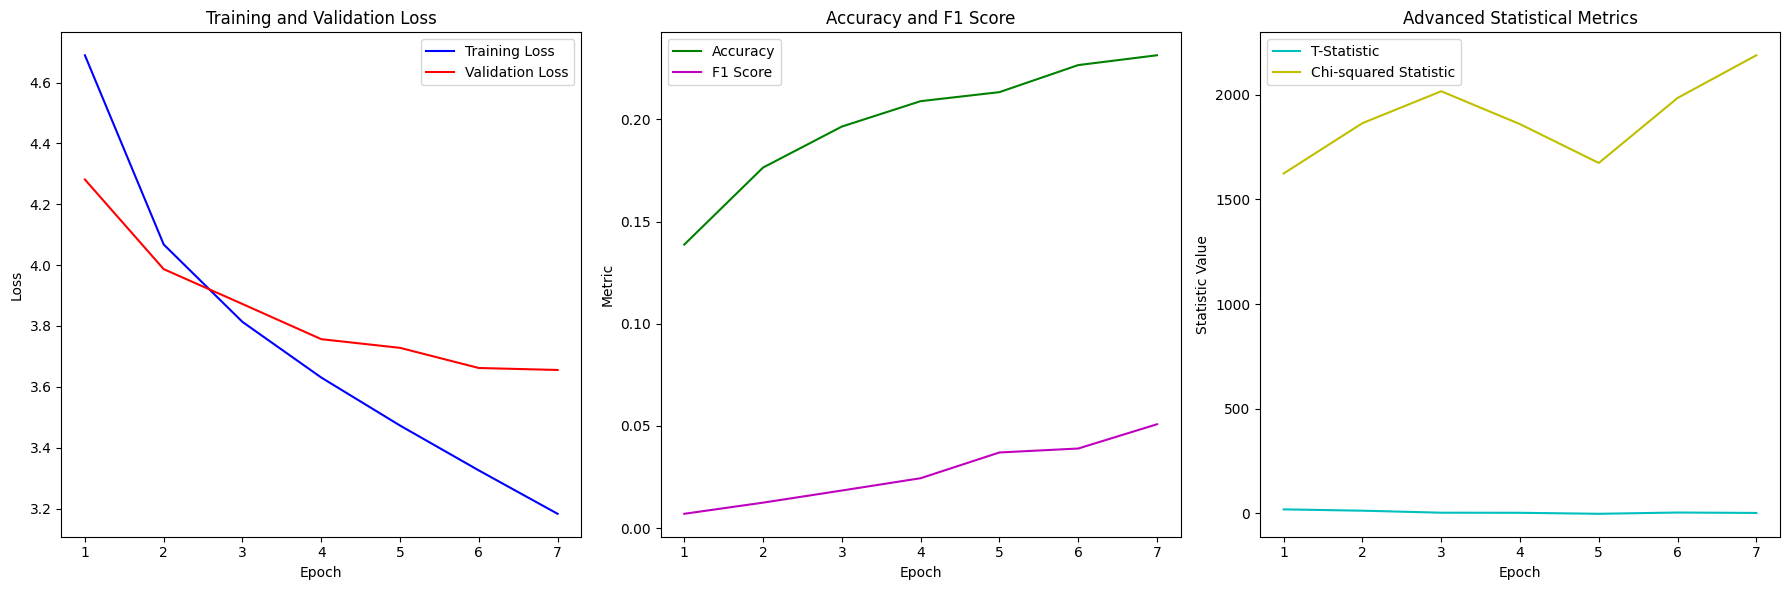

Question: what is in between the air conditioner and the rack
Image ID: image77


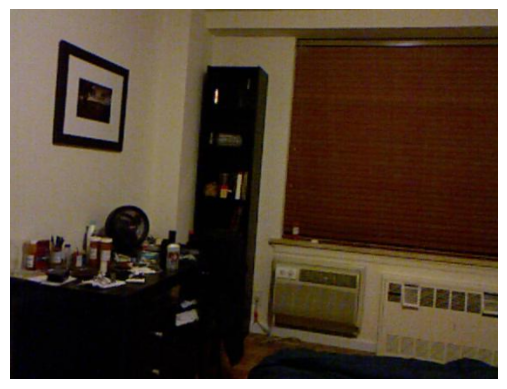

Actual Answer: cables
Predicted Answer: television

Question: what is to the opposite side of the sofa
Image ID: image1213


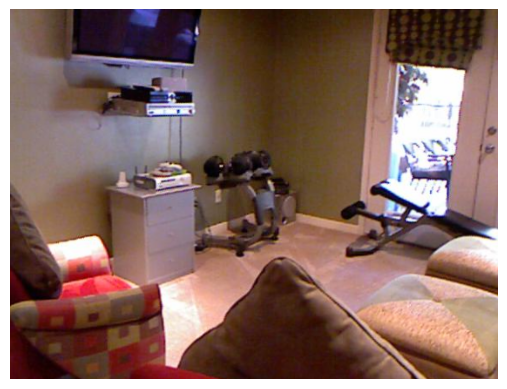

Actual Answer: door_way
Predicted Answer: table

Question: what is the object right of the screen
Image ID: image501


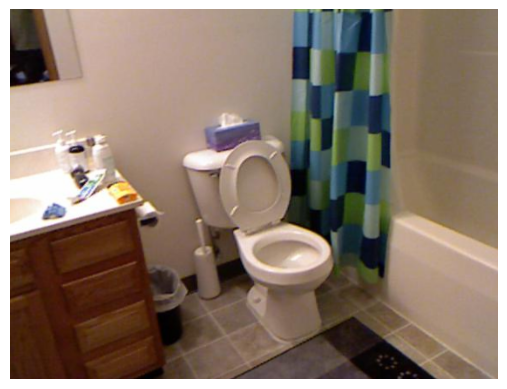

Actual Answer: bathtub
Predicted Answer: refridgerator

Question: what is in front of the cupboard
Image ID: image110


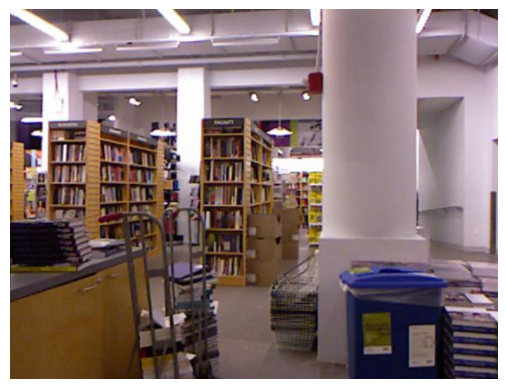

Actual Answer: stand
Predicted Answer: chair



In [20]:
# Plot the metrics after training
plot_metrics(training_losses, validation_losses, accuracies, f1_scores, t_stats, chi2_stats)

def display_predictions(model, dataset, tokenizer, preprocessor, num_examples=4):
    model.eval()
    samples = dataset['test'].shuffle(seed=42).select(range(num_examples))  # Get random samples
    predictions = []
    actuals = []
    
    for sample in samples:
        # Process the input
        input_data = collator([sample])
        input_ids = input_data['input_ids'].to(device)
        pixel_values = input_data['pixel_values'].to(device)  # Ensure this line is correctly ended
        labels = input_data['labels'].to(device)

        # Generate prediction
        with torch.no_grad():
            _, logits = model(input_ids, pixel_values, labels)
            predicted = logits.argmax(-1)
            predictions.append(predicted.item())
            actuals.append(labels.item())

        # Display results
        print(f"Question: {sample['question']}")
        print(f"Image ID: {sample['image_id']}")
        img_path = os.path.join("dataset", "images", sample['image_id'] + ".png")
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.show()
        print(f"Actual Answer: {answer_space[labels.item()]}")
        print(f"Predicted Answer: {answer_space[predicted.item()]}\n")

# Assuming model, dataset, tokenizer, preprocessor are properly defined and initialized
display_predictions(model, dataset, tokenizer, preprocessor, num_examples=4)